# Glicko testbeds

[Glicko paper](http://glicko.net/glicko/glicko.pdf)

This code is released under the [Unlicense](https://unlicense.org/).

In [1]:
import math


NEW_RATING = 1500
NEW_RD = 350
C = 0

q = math.log(10) / 400


class Rating:
    def __init__(self, r=NEW_RATING, rd=NEW_RD):
        self.r = r
        self.rd = rd
    
    def _e(self, opponent):
        return 1 / (1 + 10**(-opponent._g()*(self.r - opponent.r)/400))
    
    def _g(self, rd=None):
        if not rd:
            rd = self.rd
        return 1 / math.sqrt((1 + 3*q**2*rd**2/math.pi**2))
                
    def update(self, wins=[], losses=[], draws=[]):
        d2 = (q**2 * sum(
            opponent._g()**2 * self._e(opponent) * (1 - self._e(opponent))
            for opponent in wins+losses+draws
        ))**-1
        
        r = (
            self.r + (q/(1/self.rd**2 + 1/d2)) * sum(
            opponent._g() * (score - self._e(opponent))
            for score, opponent in (
                [(1, opponent) for opponent in wins] +
                [(0, opponent) for opponent in losses] + 
                [(.5, opponent) for opponent in draws]
            ))
        )
        
        rd = math.sqrt((1/self.rd**2 + 1/d2)**-1)
        
        return Rating(r, rd)
    
    def expected(self, opponent):
        return 1 / (1 + 10**(
            -self._g(math.sqrt(self.rd**2 + opponent.rd**2))*(self.r - opponent.r)/400)
        )

    def __str__(self):
        return f'r={self.r} rd={self.rd}'

In [2]:
# Examples from paper

player = Rating(1500, 200)
wins = [
    Rating(1400, 30),
]
losses = [
    Rating(1550, 100),
    Rating(1700, 300),
]
print(player.update(wins, losses))
print(Rating(1400, 80).expected(Rating(1500, 150)))

r=1464.1064627569112 rd=151.39890244796933
0.3759876557136924


## Basic with two players

Games		Error
1		0.20825069378141306
10		0.11428298059864189
20		0.0880052951923041
30		0.07074947450364229
40		0.060728172479441456
50		0.054441579128386416
60		0.04972422425718968
70		0.04484551032787287
80		0.04208931855200979
90		0.03886493405187572
100		0.03698330298056815


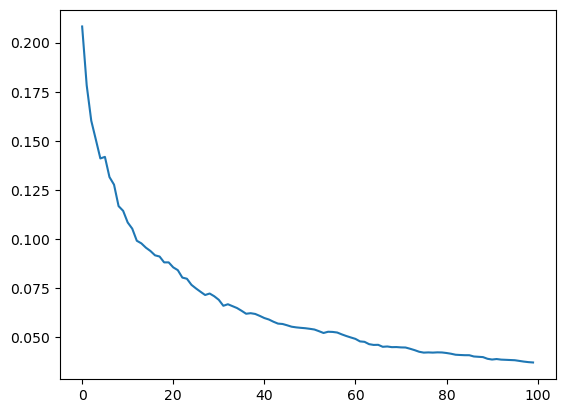

In [3]:
import random
from matplotlib import pyplot as plt


TRIALS = 1000
GAMES = 100

def trial():
    p1_win_rate = random.random()
    p1 = Rating()
    p2 = Rating()

    errors = []
    wins = 0
    for _ in range(GAMES):
        if random.random() < p1_win_rate:
            n1 = p1.update(wins=[p2])
            n2 = p2.update(losses=[p1])
            wins += 1
        else:
            n1 = p1.update(losses=[p2])
            n2 = p2.update(wins=[p1])
        p1 = n1
        p2 = n2

        errors.append(abs(p1.expected(p2) - p1_win_rate))

    return errors

errors = [0] * GAMES
for _ in range(TRIALS):
    trial_errors = trial()
    for i, error in enumerate(errors):
        errors[i] += trial_errors[i]

errors = [error/TRIALS for error in errors]
        
print('Games\t\tError')
for i in [0] + list(range(9, GAMES, 10)):
    print(f'{i+1}\t\t{errors[i]}')
    
plt.plot(errors)


## Multiple players with strengths following normal distributions

Player games	Total games	Error
1		4		0.2660765093079937
2		8		0.19449838453992704
3		12		0.15966050870022208
4		16		0.13509593815147167
5		20		0.12036755589111829
6		24		0.11065767285261419
7		28		0.09926599477009275
8		32		0.09117649394964582
9		36		0.08428992774300594
10		40		0.07987254012607817
11		44		0.07586396250153686
12		48		0.07231722050155646
13		52		0.06829408623319076
14		56		0.0663069259027676
15		60		0.0639246106140883
16		64		0.06156680269025902
17		68		0.059979757292969255
18		72		0.058137673646551404
19		76		0.05687552809905355
20		80		0.05570160909008139


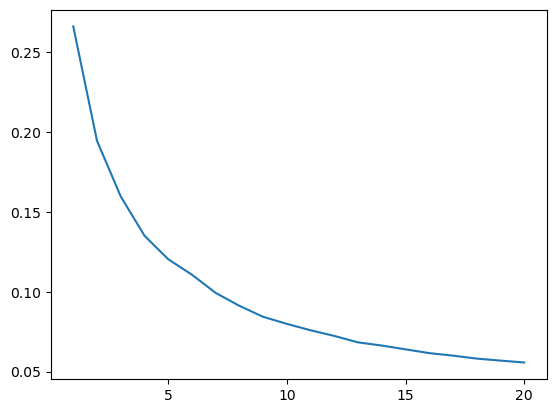

In [4]:
import random

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


TRIALS = 100
# Every player will play this many games against random opponents
GAMES = 20
PLAYERS = 4
U_RANGE = 100
S_RANGE = 10

errors = [0 for _ in range(GAMES)]
for _ in range(TRIALS):
    strengths = [
        norm(random.randrange(U_RANGE), random.randrange(1, S_RANGE))
        for _ in range(PLAYERS)
    ]
    ratings = [Rating() for _ in range(PLAYERS)]
    win_ps = np.zeros((PLAYERS, PLAYERS))
    for p1 in range(PLAYERS):
        for p2 in range(PLAYERS):
            win_ps[p1][p2] = norm(
                strengths[p1].mean() - strengths[p2].mean(),
                math.sqrt(strengths[p1].std()**2 + strengths[p2].std()**2)
            ).sf(0)

    for i in range(GAMES):
        for p1 in range(PLAYERS):
            p2 = random.randrange(PLAYERS)
            while p1 == p2:
                p2 = random.randrange(PLAYERS)
            
            win_p = win_ps[p1][p2]
            
            if random.random() < win_p:
                n1 = ratings[p1].update(wins=[ratings[p2]])
                n2 = ratings[p2].update(losses=[ratings[p1]])
            else:
                n1 = ratings[p1].update(losses=[ratings[p2]])
                n2 = ratings[p2].update(wins=[ratings[p1]])
            ratings[p1] = n1
            ratings[p2] = n2
        
        for p1 in range(PLAYERS):
            for p2 in range(p1+1, PLAYERS):
                win_p = win_ps[p1][p2]
                errors[i] += abs(ratings[p1].expected(ratings[p2]) - win_p)
            
# This is the error of the predictive accuracy of all player ratings
# after every player has played x games against random opponents
errors = [error/TRIALS/math.factorial(PLAYERS-1) for error in errors]

print('Player games\tTotal games\tError')
for i, error in enumerate(errors):
    print(f'{i+1}\t\t{(i+1)*PLAYERS}\t\t{error}')

plt.locator_params(axis='x', integer=True)
plt.plot(range(1, GAMES+1), errors)

## Open questions:

- Right now we're updating ratings immediately after a game. How do things change if we include more games in a rating period?
- What do actual ratings and (especially) rd values look as time goes on? How closely does rd relate to the error?